In [28]:
from matplotlib import pyplot as plt, animation
import numpy as np
import pysindy as ps
from math import pi
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField
from my_handy_functions import *

In [3]:
def plot_solution(x, y, u, main_str, t=0):
    plt.figure()
    plot_u = np.transpose(u, (0, 2, 1))
    plt.pcolormesh(x, y, plot_u[t])
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.title(main_str, fontsize=16)
    plt.colorbar()

def animate_solution(x, y, u, main_str):
    fig, ax = plt.subplots()
    ax.set_xlabel("x", fontsize=16); ax.set_ylabel("y", fontsize=16)
    ax.set_title(main_str, fontsize=16)

    plot_u = np.transpose(u, (0, 2, 1))
    cax = ax.pcolormesh(x, y, plot_u[0,:,:])
    fig.colorbar(cax)
    
    def change_frame(i):
        cax.set_array(plot_u[i,:,:].flatten())
    
    anim = animation.FuncAnimation(fig, change_frame, interval=100, frames=len(u[:,0,0]) - 1)
    anim.save(main_str + ".gif")

In [20]:
a = 1  # wave speed in x direction  --- do these actually work?
b = 2  # wave speed in y direction
equation = PDE({"u": f"- {a} * d_dx(u) - {b} * d_dy(u)"},
                # bc={"value": "cos(x)"}
                )

x_min = 0
x_max = pi*2
x_num_elements = 128

y_min = -pi
y_max = pi
y_num_elements = 128

grid = CartesianGrid([[x_min, x_max], [y_min, y_max]], [x_num_elements, y_num_elements], periodic=True)
state = ScalarField.from_expression(grid, "sin(x) + cos(y)")

t_max = pi
t_num_elements = 64

storage = MemoryStorage()
result = equation.solve(state, t_range=t_max, tracker=storage.tracker(t_max/t_num_elements))

[x, y] = storage.grid.axes_coords
t = np.ravel(storage.times)
u = np.real(storage.data)

In [18]:
# plot_solution(x, y, u, "u")

In [30]:
u_reshaped = np.expand_dims(np.transpose(u, [1, 2, 0]), axis=3)

X, Y = np.meshgrid(x, y, indexing='ij')
XY = np.transpose([X, Y], [1, 2, 0])

library_functions = [
    lambda x: x,
    lambda x: x * x,
    lambda x, y: x * y,
]
library_function_names  = [
    lambda x: x,
    lambda x: x + x,
    lambda x, y: x + y,
]

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=XY,
                        include_bias=True, is_uniform=True
                        )

opt = ps.STLSQ(threshold=1, alpha=1e-5, normalize_columns=True)
# opt = ps.SR3(threshold=0.1, thresholder="l1", max_iter=1000, normalize_columns=True, tol=1e-1)
model = ps.SINDy(feature_library=pde_lib, optimizer=opt, feature_names='u',
                #  differentiation_method=ps.SpectralDerivative
                 )

dt = t[1]-t[0]
model.fit(u_reshaped, t=dt)
print_result(model, "u")

Feature library:
['1', 'u', 'uu', 'u_y', 'u_x', 'uu_y', 'uuu_y', 'uu_x', 'uuu_x']
STLSQ model:
(u)' = -1.997 u_2 + -1.000 u_1


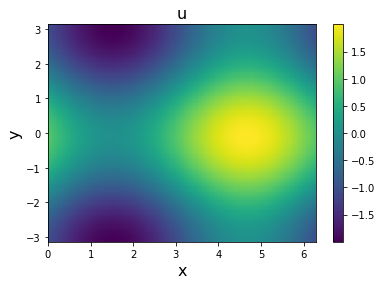

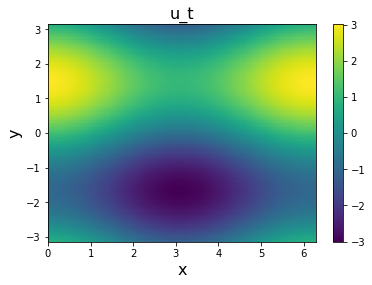

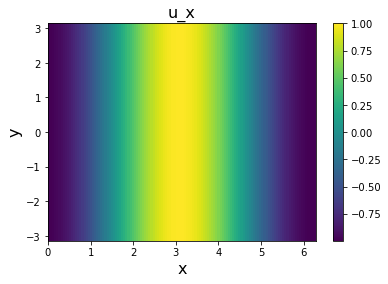

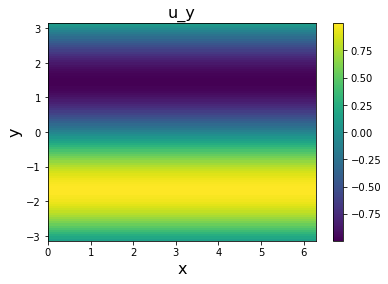

In [16]:
animate_solution(x, y, u, "u")

labels = ["t", "x", "y"]
values = [t, x, y]
for i, (l, v) in enumerate(zip(labels, values)):
    dv = v[1] - v[0]
    for j in range(1, 2):
        u_i = ps.FiniteDifference(d=j, axis=i)._differentiate(u, t=dv)
        animate_solution(x, y, u_i, "u_{}".format(l*j))

![SegmentLocal](u.gif "segment")
![SegmentLocal](u_t.gif "segment")
![SegmentLocal](u_x.gif "segment")
![SegmentLocal](u_y.gif "segment")

In [25]:
pde_lib.get_feature_names('u')

['1', 'u', 'uu', 'u_2', 'u_1', 'uu_2', 'uuu_2', 'uu_1', 'uuu_1']